In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from glob import glob

In [3]:
train_path = "/content/drive/MyDrive/Colab Notebooks/bitirme/train"
test_path = "/content/drive/MyDrive/Colab Notebooks/bitirme/test"

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/Colab Notebooks/bitirme/train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/bitirme/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training resimleri:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing resimleri:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training resimleri:
Found 2380 images belonging to 29 classes.
Testing resimleri:
Found 594 images belonging to 29 classes.


In [5]:
# Tensorboard callback işlevini oluşturma
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"TensorBoard günlük dosyalarını kaydetme: {log_dir}")
  return tensorboard_callback


In [6]:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Resnet 50 V2 özellik vektörü
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
# EfficientNet0 özellik vektörü
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
def create_model(model_url, num_classes=29):

  # Önceden eğitilmiş modeli indirin ve Keras katmanı olarak kaydedin
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # temel kalıpları dondur
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # giriş görüntü şeklini tanımla

  # Kendi modelimizi oluşturun
  model = tf.keras.Sequential([
    feature_extractor_layer, # özellik çıkarma katmanını temel olarak kullanın
    layers.Dense(num_classes, activation='softmax', name='output_layer') # kendi çıktı katmanımızı yarat
  ])

  return model

In [9]:
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Derleme
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [10]:
resnet_history = resnet_model.fit(train_data,
                   epochs=5,
                   steps_per_epoch=len(train_data),
                   validation_data=test_data,
                   validation_steps=len(test_data),
                   callbacks=[
                        create_tensorboard_callback(
                            # buraya kaydet
                            dir_name="tensorflow_hub",
                            # log dosyalarının adı
                            experiment_name="resnet50V2")])

TensorBoard günlük dosyalarını kaydetme: tensorflow_hub/resnet50V2/20240514-221438
Epoch 1/5
75/75 [==============================] - 1557s 21s/step - loss: 2.0840 - accuracy: 0.4542 - val_loss: 1.1199 - val_accuracy: 0.7323
Epoch 2/5
75/75 [==============================] - 18s 245ms/step - loss: 0.6278 - accuracy: 0.8987 - val_loss: 0.6140 - val_accuracy: 0.8805
Epoch 3/5
75/75 [==============================] - 19s 251ms/step - loss: 0.3203 - accuracy: 0.9655 - val_loss: 0.4063 - val_accuracy: 0.9394
Epoch 4/5
75/75 [==============================] - 19s 252ms/step - loss: 0.2008 - accuracy: 0.9807 - val_loss: 0.3189 - val_accuracy: 0.9478
Epoch 5/5
75/75 [==============================] - 19s 255ms/step - loss: 0.1404 - accuracy: 0.9895 - val_loss: 0.2692 - val_accuracy: 0.9562


In [11]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [12]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])


In [13]:
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])

TensorBoard günlük dosyalarını kaydetme: tensorflow_hub/efficientnetB0/20240514-224249
Epoch 1/5
75/75 [==============================] - 34s 308ms/step - loss: 2.6034 - accuracy: 0.3958 - val_loss: 1.9210 - val_accuracy: 0.6330
Epoch 2/5
75/75 [==============================] - 19s 249ms/step - loss: 1.3910 - accuracy: 0.8366 - val_loss: 1.2263 - val_accuracy: 0.8333
Epoch 3/5
75/75 [==============================] - 19s 256ms/step - loss: 0.8613 - accuracy: 0.9282 - val_loss: 0.8920 - val_accuracy: 0.8805
Epoch 4/5
75/75 [==============================] - 18s 244ms/step - loss: 0.5905 - accuracy: 0.9618 - val_loss: 0.6808 - val_accuracy: 0.8923
Epoch 5/5
75/75 [==============================] - 20s 268ms/step - loss: 0.4404 - accuracy: 0.9681 - val_loss: 0.5504 - val_accuracy: 0.9209


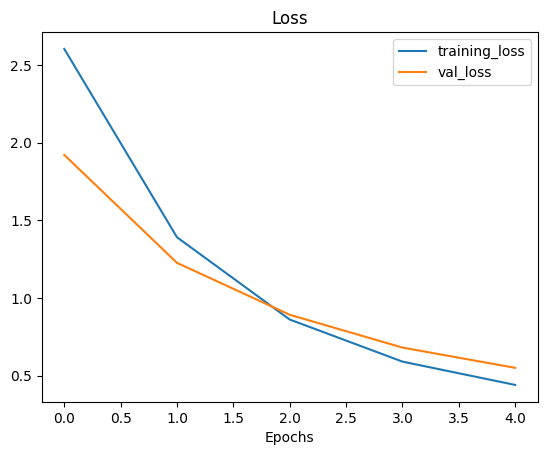

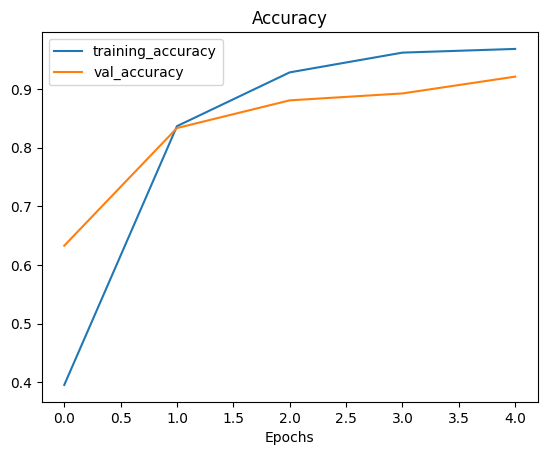

In [14]:
plot_loss_curves(efficientnet_history)

In [15]:
fine_model = resnet_model

In [16]:

fine_model.trainable = True

for layer in fine_model.layers[:-10]:
  layer.trainable = False

fine_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [17]:
fine_tune_epochs = 10


history_fine = fine_model.fit(train_data,
                epochs=fine_tune_epochs,
                validation_data=test_data,
                validation_steps=int(0.25 * len(test_data)),
                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                 experiment_name="fine_tune_last_10")])


TensorBoard günlük dosyalarını kaydetme: transfer_learning/fine_tune_last_10/20240514-224459
Epoch 1/10
75/75 [==============================] - 60s 370ms/step - loss: 0.9731 - accuracy: 0.8008 - val_loss: 7.3033 - val_accuracy: 0.2578
Epoch 2/10
75/75 [==============================] - 24s 323ms/step - loss: 0.4958 - accuracy: 0.9399 - val_loss: 1.8062 - val_accuracy: 0.6719
Epoch 3/10
75/75 [==============================] - 24s 317ms/step - loss: 0.4139 - accuracy: 0.9706 - val_loss: 0.5077 - val_accuracy: 0.9453
Epoch 4/10
75/75 [==============================] - 24s 313ms/step - loss: 0.4537 - accuracy: 0.9630 - val_loss: 2.1567 - val_accuracy: 0.6641
Epoch 5/10
75/75 [==============================] - 25s 334ms/step - loss: 0.4278 - accuracy: 0.9723 - val_loss: 0.7423 - val_accuracy: 0.9062
Epoch 6/10
75/75 [==============================] - 24s 321ms/step - loss: 0.4810 - accuracy: 0.9618 - val_loss: 2.5671 - val_accuracy: 0.6172
Epoch 7/10
75/75 [==============================]